
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>


В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [ ]:
import os
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder, DatasetFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/MyDrive//DATA/archive.zip'

          No such file or directory


In [ ]:
data_dir = './data'

In [ ]:
image_size = 128
batch_size = 64
random_state = 69

In [ ]:
def get_dataloader(image_size, batch_size):
  transform = tt.Compose([
    tt.Resize(image_size),
    tt.ToTensor(),
    tt.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])
  
  dataset = ImageFolder(data_dir, transform=transform)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
  return dataloader

In [ ]:
dataloader = get_dataloader(image_size=image_size, batch_size=batch_size)

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
dataloader = DeviceDataLoader(dataloader, device)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=4, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 1024 x 4 x 4

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 64 x 64

    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 32 x 128 x 128

    nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=2, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 32 x 128 x 128

    nn.ConvTranspose2d(32, 16, kernel_size=4, stride=1, padding=1, bias=False),
    nn.BatchNorm2d(16),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 16 x 128 x 128

    nn.ConvTranspose2d(16, 8, kernel_size=4, stride=1, padding=1, bias=False),
    nn.BatchNorm2d(8),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 8 x 128 x 128

    nn.ConvTranspose2d(8, 3, kernel_size=3, stride=1, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)

In [ ]:
generator = to_device(generator, device)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
lr = 0.0001
epochs  = 40

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

# Фиксированный шум, используемый для генерации изображений после каждой эпохи
fixed_noise = torch.randn(64, latent_size, 1, 1, device=device)

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def denorm(img_tensors):
  stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
  return img_tensors * stats[1][0] + stats[0][0]

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(dataloader):
            # Train discriminator
            real_images = real_images.to(device)
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        # Save generated images
        if epoch == epochs - 1:
          save_samples(epoch+start_idx, fixed_noise, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
losses_g, losses_d, real_scores, fake_scores = fit(model, criterion, epochs, lr)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/40], loss_g: 5.4430, loss_d: 0.7508, real_score: 0.8012, fake_score: 0.3407


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [2/40], loss_g: 6.3895, loss_d: 0.1905, real_score: 0.9391, fake_score: 0.1043


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [3/40], loss_g: 5.9660, loss_d: 0.0775, real_score: 0.9739, fake_score: 0.0446


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [4/40], loss_g: 5.9505, loss_d: 0.0569, real_score: 0.9797, fake_score: 0.0210


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [5/40], loss_g: 6.8597, loss_d: 0.4823, real_score: 0.8967, fake_score: 0.0777


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [6/40], loss_g: 5.1064, loss_d: 0.1860, real_score: 0.9209, fake_score: 0.0639


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [7/40], loss_g: 5.5662, loss_d: 0.2418, real_score: 0.9054, fake_score: 0.0809


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [8/40], loss_g: 5.4935, loss_d: 0.1953, real_score: 0.9229, fake_score: 0.0765


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [9/40], loss_g: 6.9107, loss_d: 0.2322, real_score: 0.9112, fake_score: 0.0800


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [10/40], loss_g: 7.1267, loss_d: 0.2669, real_score: 0.9005, fake_score: 0.0893


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [11/40], loss_g: 5.7284, loss_d: 0.4600, real_score: 0.8584, fake_score: 0.1381


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [12/40], loss_g: 5.0966, loss_d: 0.3452, real_score: 0.8705, fake_score: 0.1321


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [13/40], loss_g: 4.8292, loss_d: 0.4501, real_score: 0.8571, fake_score: 0.1428


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [14/40], loss_g: 4.9115, loss_d: 0.6379, real_score: 0.7955, fake_score: 0.1901


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [15/40], loss_g: 5.0297, loss_d: 0.5709, real_score: 0.8180, fake_score: 0.1710


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [16/40], loss_g: 5.3200, loss_d: 0.5162, real_score: 0.8239, fake_score: 0.1687


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [17/40], loss_g: 4.5150, loss_d: 0.4614, real_score: 0.8359, fake_score: 0.1636


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [18/40], loss_g: 4.8375, loss_d: 0.4617, real_score: 0.8346, fake_score: 0.1626


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [19/40], loss_g: 4.3194, loss_d: 0.5045, real_score: 0.8216, fake_score: 0.1731


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [20/40], loss_g: 4.4210, loss_d: 0.6466, real_score: 0.7862, fake_score: 0.2131


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [21/40], loss_g: 3.9907, loss_d: 0.6580, real_score: 0.7771, fake_score: 0.2109


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [22/40], loss_g: 4.3060, loss_d: 0.6193, real_score: 0.7939, fake_score: 0.2061


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [23/40], loss_g: 4.6686, loss_d: 0.5645, real_score: 0.8112, fake_score: 0.1872


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [24/40], loss_g: 4.2548, loss_d: 0.5850, real_score: 0.7984, fake_score: 0.1934


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [25/40], loss_g: 4.1957, loss_d: 0.6214, real_score: 0.7880, fake_score: 0.1925


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [26/40], loss_g: 3.7564, loss_d: 0.5908, real_score: 0.7949, fake_score: 0.2155


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [27/40], loss_g: 4.0440, loss_d: 0.6930, real_score: 0.7728, fake_score: 0.2146


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [28/40], loss_g: 3.8551, loss_d: 0.6295, real_score: 0.7958, fake_score: 0.2096


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [29/40], loss_g: 3.9700, loss_d: 0.6437, real_score: 0.7746, fake_score: 0.2193


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [30/40], loss_g: 3.5896, loss_d: 0.6523, real_score: 0.7702, fake_score: 0.2217


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [31/40], loss_g: 4.1027, loss_d: 0.6599, real_score: 0.7830, fake_score: 0.2220


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [32/40], loss_g: 3.6147, loss_d: 0.7057, real_score: 0.7574, fake_score: 0.2446


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [33/40], loss_g: 3.5680, loss_d: 0.6282, real_score: 0.7728, fake_score: 0.2262


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [34/40], loss_g: 3.8355, loss_d: 0.6673, real_score: 0.7711, fake_score: 0.2298


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [35/40], loss_g: 3.6120, loss_d: 0.6847, real_score: 0.7583, fake_score: 0.2342


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [36/40], loss_g: 3.6672, loss_d: 0.7241, real_score: 0.7628, fake_score: 0.2440


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [37/40], loss_g: 3.3438, loss_d: 0.5916, real_score: 0.7775, fake_score: 0.2130


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [38/40], loss_g: 3.9724, loss_d: 0.7554, real_score: 0.7541, fake_score: 0.2438


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [39/40], loss_g: 3.5810, loss_d: 0.6268, real_score: 0.7780, fake_score: 0.2301


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [40/40], loss_g: 3.7019, loss_d: 0.6764, real_score: 0.7634, fake_score: 0.2265
Saving generated-images-0040.png


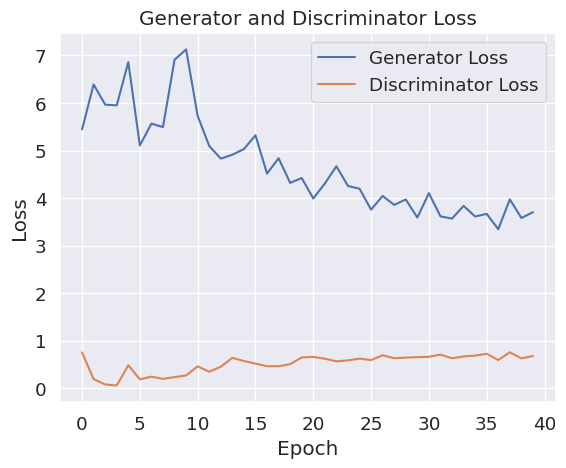

In [ ]:
# Построение графика лосса для генератора
plt.plot(losses_g, label='Generator Loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Loss')
plt.legend()
plt.show()

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

Как видно на графике, лосс дискриминатора имеет отрицательный тренд, модель все хуже отличала оригинал от фейка, а лос генератора имеет чуть положительный тренд хотя за примерно держиться на одном уровне.

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

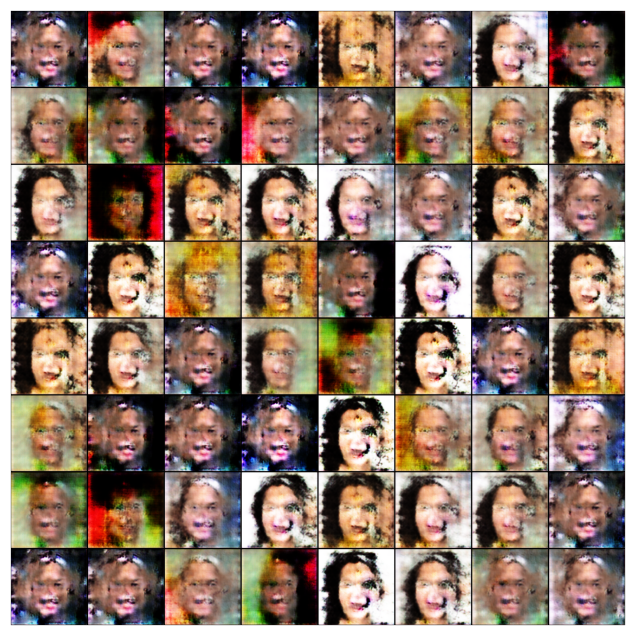

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)
generated_img = cv2.imread(f'./generated/generated-images-00{epochs}.png')
generated_img = generated_img[:, :, [2, 1, 0]]
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

Как вам качество получившихся изображений?

Качество изображений получилось не совсем хорошее, но очертания лиц примерное видно, хотя у всех примерно почти одно формы.

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score

In [ ]:
transform = tt.Compose([
    tt.Resize(image_size),
    tt.ToTensor(),
    tt.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

In [ ]:
dataset = ImageFolder(data_dir, transform=transform)

In [ ]:
len(dataset)

2819

In [ ]:
# 1000 real images from dataset
real_images = [data[0] for data in dataset][:1000]
real_labels = torch.ones(len(real_images))

In [ ]:
# 1000 fake images from trained generator 1000
fixed_latent = torch.randn(1000, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)
fake_labels = torch.zeros(1000)

In [ ]:
real_images_tensor = torch.stack(real_images)

In [ ]:
print(f'fake_images shape : {fake_images.shape}')
print(f'real_images_tensor shape : {real_images_tensor.shape}')

fake_images shape: torch.Size([1000, 3, 128, 128])
real_images_tensor shape: torch.Size([1000, 3, 128, 128])


In [ ]:
# concat images and labels
all_images = torch.cat([to_device(fake_images,device), to_device(real_images_tensor,device)], dim=0)
all_labels = torch.cat([to_device(fake_labels,device), to_device(real_labels,device)], dim=0)

In [ ]:
# KNN 
knn = KNeighborsClassifier(n_neighbors=1)

# X - images 4d tensor to 2d numpy
X = all_images.detach().cpu().numpy().reshape(all_images.shape[0], -1)

# Y - labels
y = all_labels.detach().cpu().numpy().flatten()

# Knn and loo
knn = KNeighborsClassifier(n_neighbors=1)
loo = LeaveOneOut()

In [ ]:
# train
accuracies = []
for train_index, test_index in loo.split(X):
    # train test split (loo)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # fit
    knn.fit(X_train, y_train)

    # prediction
    y_pred = knn.predict(X_test)

    # accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# mean accuracy
mean_accuracy = np.mean(accuracies)

print("Leave-One-Out Accuracy:", mean_accuracy)

Leave-One-Out Accuracy: 0.9865


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Accuracy: 0.9865 - это плохой результат, иделаьный был бы 0.5 то есть модель не может отличить оригинал от фейка.

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

In [ ]:
tsne = TSNE(n_components=2)

In [ ]:
tsne_results = tsne.fit_transform(X)

In [ ]:
fig = px.scatter(tsne_results, x=0, y=1, color=y.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

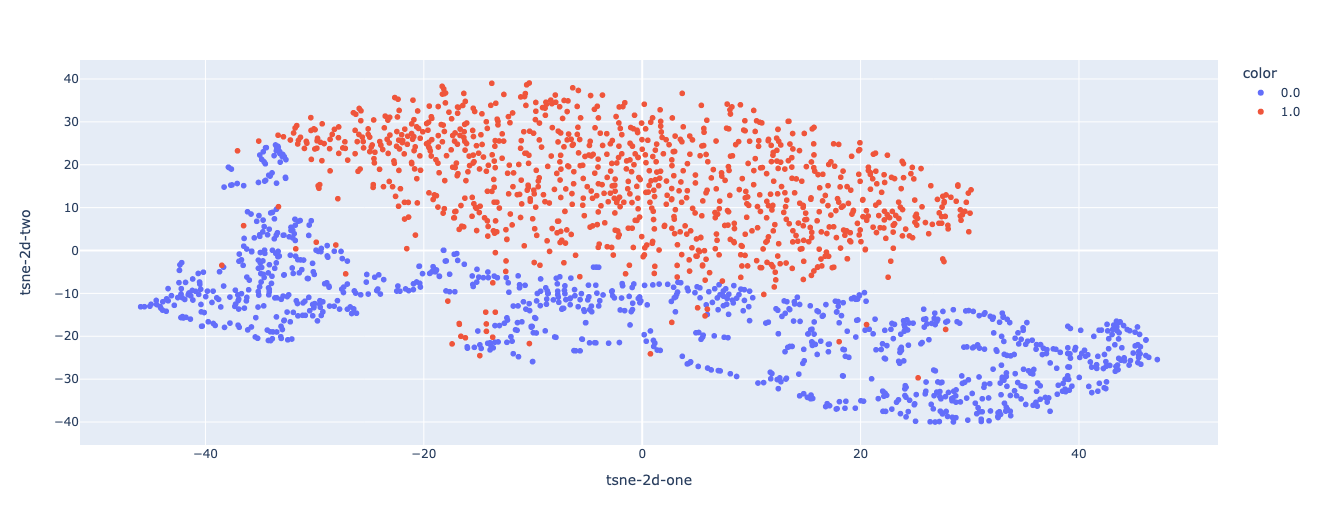

Прокомментируйте получившийся результат:

Как видно на графике, есть пересечение двух калсов и примерно одинаковые формы, но имеет сильно смещение распределений оригинальных изображений от сгенерированных.

ВЫВОД:

В этой тетрадке мы обучили GAN на маленьком датасете(~3000 картинок). Получили не самые лучшие сгенерированные изображения, и не лучшие распределения, но наша главная цель была НАУЧИТЬСЯ это технике.

Для улучшения результатов требуется:


*   Увеличение размера и разнообразия обучающего набора данных
*   Увеличение сложности модели генератора
*   Увеличение числа эпох обучения
*   Уменьшение числа батчей

  и т.д.